# PII Data Exploration Notebook

## Introduction
Welcome to the PII Data Exploration Notebook! In this notebook, we will be exploring a dataset containing school essays that may contain personal identifiable information (PII). Our goal is to develop a system that can classify and mask any PII present in the essays.

As we are dealing with sensitive data, it is crucial to ensure the privacy and security of individuals. Therefore, we will focus on feature extraction of the tokens in order to create a more interpretable model. By understanding the characteristics and patterns of the PII tokens, we can develop effective strategies for classification and masking.


## Notebook Structure

This notebook is structured as follows:

1. **Data loading and preparation**: loading the dataset and preparing variables and reoccuring functions.

2. **General data overview**: understand the data a bit more, e.g. how long the documents are, label imbalance etc.

3. **More in-depth analysis**: looking more closely at each label and how it behaves, what it contains etc., specifically:
    1. **Distributions** of positional encoding, length, capital letters etc.
    2. **Correlations** on co-occcurence
    3. **Similarities** based on N-grams and PCA
    4. **Context** of the words, what each label typically contains
    5. **Label specific** analysis, e.g. gender, ethnicity etc.


Let's get started with the data exploration!


---

# Data loading and preparation

The dataset consists of a collection of school essays, each accompanied by a set of labels indicating the presence of PII. The labels follow the BIO format, where "B" represents the beginning of a PII entity, "I" represents the continuation of a PII entity, and "O" represents non-PII tokens.

---

In [1]:
# import necesasry libraries
import json
import random
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.graph_objects as go
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import gender_guesser.detector as gender
from ethnicseer import EthnicClassifier;



Let's start by loading the data.

In [2]:
file_path = "../data/train.json"

with open(file_path, "r") as file:
    data = json.load(file)
df = pd.DataFrame(data)
print(f"Number of samples: {len(df)}")
print(f"Columns: {[col for col in df.columns]}")
df.head()

Number of samples: 6807
Columns: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels']


,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


Looking at a single example of an essay.

In [3]:
print(df.iloc[0]['full_text'])

Design Thinking for innovation reflexion-Avril 2021-Nathalie Sylla

Challenge & selection

The tool I use to help all stakeholders finding their way through the complexity of a project is the  mind map.

What exactly is a mind map? According to the definition of Buzan T. and Buzan B. (1999, Dessine-moi  l'intelligence. Paris: Les Éditions d'Organisation.), the mind map (or heuristic diagram) is a graphic  representation technique that follows the natural functioning of the mind and allows the brain's  potential to be released. Cf Annex1

This tool has many advantages:

•  It is accessible to all and does not require significant material investment and can be done  quickly

•  It is scalable

•  It allows categorization and linking of information

•  It can be applied to any type of situation: notetaking, problem solving, analysis, creation of  new ideas

•  It is suitable for all people and is easy to learn

•  It is fun and encourages exchanges

•  It makes visible the dimension of pr

From the example above we see that for e.g. the task of finding student names, here *Nathalie Sylla*, there also appear to be other names present, in this case *Buzan T. and Buzan B.* which should instead be classified as `O`. This further complicates the task and indicates the necessity of more context aware models such as LLMs.


#### Preparing

Preparing useful variables and reoccuring functions.

In [4]:
# print all length and all unique labels
lables_list = np.concatenate(df['labels'].values)
labels = sorted(list(set(lables_list)))
print(f"Number of unique labels: {len(labels)}")
print(f"Unique labels:")
for label in labels:
    print(f"  {label}")

# ignoring the BIO format
labels_not_bio = list(dict.fromkeys([label[2:] if label != "O" else 'O' for label in labels]))
print(f"\nNumber of unique labels (ignoring the BIO format): {len(labels_not_bio)}")

# Conversion variables
# id conversion
id2label = dict(enumerate(labels)) 
label2id = {v:k for k,v in id2label.items()}
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'pink', 'brown', 'black', 'gray', 'cyan', 'magenta', 'yellow']
label2color = {label: colors[i] for i, label in enumerate(labels)}
# other
num_labels = len(labels)
# BIO format to not BIO format label mapping
bio2notbio = {label: label[2:] if label != "O" else 'O' for label in labels}
notbio2bio = {label: [] for label in labels_not_bio}
for key, value in bio2notbio.items():
    notbio2bio[value].append(key)

Number of unique labels: 13
Unique labels:
  B-EMAIL
  B-ID_NUM
  B-NAME_STUDENT
  B-PHONE_NUM
  B-STREET_ADDRESS
  B-URL_PERSONAL
  B-USERNAME
  I-ID_NUM
  I-NAME_STUDENT
  I-PHONE_NUM
  I-STREET_ADDRESS
  I-URL_PERSONAL
  O

Number of unique labels (ignoring the BIO format): 8


Not all labels consist of the full BIO format - i.e. not utilizing the continuation prefix `I`

In [5]:
def get_additional_data(dtype='word_list', labels=None):
    label_2_something = {label: [] for label in labels}
    # iterate over the data
    for i, row in tqdm(df.iterrows(), total=len(df)):
        n_tokens = len(row['tokens'])
        for label in labels:
            if dtype == 'occurrences':
                label_2_something[label].append(0)
        # iterate over the tokens in a document
        for i_token, (token, label) in enumerate(zip(row['tokens'], row['labels'])):
            # store the token, length and normalized position
            if label in labels:
                if dtype == 'word_list':
                    label_2_something[label].append(token)
                elif dtype == 'word_lengths':
                    label_2_something[label].append(len(token))
                elif dtype == 'norm_positions':
                    label_2_something[label].append(i_token / n_tokens)
                elif dtype == 'occurrences':
                    label_2_something[label][i] += 1
            # store the context, watch out for the limits
            if dtype == 'context_before':
                context_before = row['tokens'][max(0, i_token-1)] if i_token > 0 else "None"
                label_2_something[label].append(context_before)
            if dtype == 'context_after':
                context_after = row['tokens'][min(n_tokens-1, i_token+1)] if i_token < n_tokens-1 else "None"
                label_2_something[label].append(context_after)
            # store the number of I's after a B-
            if label[0] == "B":
                n_i = 0
                for j_token in range(i_token+1, n_tokens):
                    if row['labels'][j_token] == f"I-{label[2:]}":
                        n_i += 1
                    else:
                        break
                if dtype == 'I_after_B':
                    label_2_something[label].append(n_i)
    return label_2_something

In [6]:
label_2_word_list = get_additional_data(dtype='word_list', labels=labels)

  0%|          | 0/6807 [00:00<?, ?it/s]

100%|██████████| 6807/6807 [00:03<00:00, 1933.15it/s]


Each `label_2_...` variable consists of a dictionary, wherein each labels stores all its words, word lengths, normalized positions irrespective of documents.

In [7]:
def data2notbio(data_dict, bio2notbio):
    """
    Convert a dictionary of data from BIO format to not BIO format.

    Parameters
    ----------
    data_dict : dict
        Dictionary with keys as BIO format labels and values as lists of data.
    bio2notbio : dict
        Dictionary mapping BIO format labels to not BIO format labels.

    Returns
    -------
    dict
        Dictionary with keys as not BIO format labels and values as lists of data.
    """
    new_data = {val: [] for val in bio2notbio.values()}
    for key, value in data_dict.items():
        new_key = bio2notbio[key]
        new_data[new_key].extend(data_dict[key])
    return new_data

In [ ]:
# function
def plot_label_occurence(unique_labels, label_counts, title="Label Occurence"):
    """
    Plot the occurence of labels in the dataset.

    Parameters
    ----------
    unique_labels : list
        List of unique labels.
    label_counts : list
        List of counts for each label.
    title : str, optional
        Title of the plot, by default "Label Occurence".
    """
    # plot a histogram of label occurences, labels on y-axis
    plt.figure(figsize=(6, 5))
    plt.barh(unique_labels, label_counts, color='brown')   
    plt.xscale("log")
    for i, count in enumerate(label_counts):
        plt.text(count, i, f" {count} ", va='center')
    plt.xlabel('Log Counts')
    plt.ylabel('Labels')
    plt.title(title)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

In [ ]:
def plot_positional_occurence(pos, title):
    """
    Plot the distribution of the positions of the tokens in the documents.

    Parameters
    ----------
    pos : list
        List of positions of the tokens in the documents.
    title : str
        Title of the plot.
    """
    # Plot lengths
    plt.figure(figsize=(9, 3))
    plt.hist(pos, bins=30, edgecolor='white', color='mediumslateblue')
    plt.xlabel("Position")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

In [ ]:
def plot_label_histograms(data, title, xlabel, O=False):
    fig, axs = plt.subplots(2, 4, figsize=(20, 8))
    axs = axs.flatten()
    for i, label in enumerate(labels_not_bio): # iterate to maintain order
        # if O is defined as a string
        if label == 'O' and isinstance(O, str):
                axs[i].axis('off')  
                axs[i].set_title(O)
        else:
            for bio_label in notbio2bio[label]:
                if len(data[bio_label]) > 1:
                    #sns.kdeplot(label_2_norm_positions[bio_label], label=bio_label, ax=axs[i], fill=True, warn_singular=False)
                    sns.histplot(data[bio_label], label=bio_label, ax=axs[i], kde=False)
            axs[i].legend()
            axs[i].set_title(label)
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel("Density")  

    fig.suptitle(title + '\n', fontsize=24)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_label_boxplotdata(data, title, ylabel):
    # boxplots
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
def barh_plot(data, title, color):
    labels, values = list(data.keys()), list(data.values())
    plt.barh(labels, values, color=color)   
    plt.xlabel('Counts')
    plt.ylabel('Labels')
    plt.title(title)
    plt.show()

In [ ]:
def plot_matrix(cm, classes,
                title='',
                cmap=plt.cm.Blues, figsize=(8, 8),
                xlabel='Predicted label', ylabel='True label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # normalize cm by the diagonal values
    # get diagonal
    diag = cm.diagonal()
    # divide each column by the diagonal
    cm = cm / diag[:, None]
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # set fig size
    plt.figure(figsize=figsize)
    plt.grid(False)
    # cm is of shape (n_classes, n_classes), e.g. [[1, 0], [0, 1]]
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title+", normalized by diagonal")
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = 0.5#cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

In [ ]:
def plot_word_cloud(data, title):
    fig, axs = plt.subplots(3, 4, figsize=(12, 6))
    axs = axs.flatten()
    i=0
    for nb_label in labels_not_bio[:-1]:
        for label in notbio2bio[nb_label]:
            try: 
                #if len(label_2_word_list[label]) <= 1:
                #    continue
                wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(data[label]))
                axs[i].imshow(wordcloud)
            except:
                # continue
                pass

            axs[i].axis('off')
            axs[i].set_title(label)
            i+=1
    fig.suptitle(title + '\n', fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_word_cloud(data, title):
    fig, axs = plt.subplots(3, 4, figsize=(12, 6))
    axs = axs.flatten()
    i=0
    for nb_label in labels_not_bio[:-1]:
        for label in notbio2bio[nb_label]:
            try: 
                #if len(label_2_word_list[label]) <= 1:
                #    continue
                wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(data[label]))
                axs[i].imshow(wordcloud)
            except:
                # continue
                pass

            axs[i].axis('off')
            axs[i].set_title(label)
            i+=1
    fig.suptitle(title + '\n', fontsize=20)
    plt.tight_layout()
    plt.show()


---

# General data overview

This section serves as an introduction to the more in-depth data analysis.

---


## Document analysis

Let's look at some analysis on the documents as a whole.

#### Distribution of document lengths

We explore the number of tokens within each document - i.e. each student essay.

Mean length: 733.44
Max length: 3298.00
Min length: 69.00


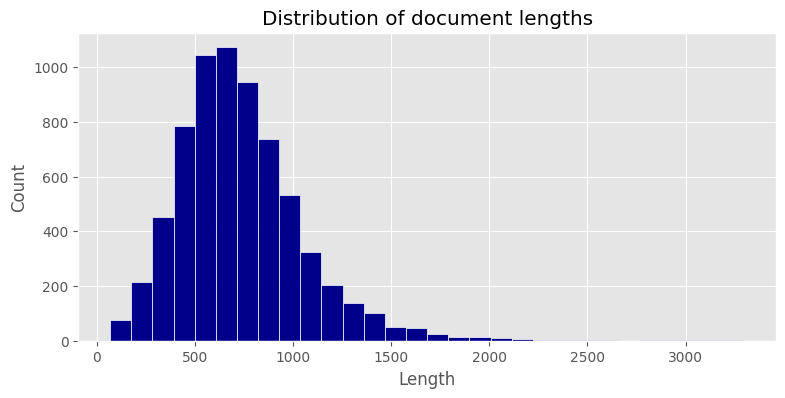

In [8]:
# Plot lengths
plt.figure(figsize=(9, 4))
lengths = df['tokens'].apply(len)
print(f"Mean length: {np.mean(lengths):.2f}")
print(f"Max length: {np.max(lengths):.2f}")
print(f"Min length: {np.min(lengths):.2f}")
# add bin space
plt.hist(lengths, bins=30, edgecolor='white', color='darkblue')
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of document lengths")
plt.show()

Generally the texts follow a normal distribution, however with a right tail. This is probably due to the nature of the texts being student texts with restrictions on their lengths - however they do vary quite a lot, with a minimum of 69 and maximum of 3298 tokens.

#### Let's check how often each label is in a document

I.e. give each label, how often on average does it occur across the documents.

In [9]:
# print average occurence per label in documents
label_2_occurrences = get_additional_data(dtype='occurrences', labels=labels)
avg_occurrences = {label: np.mean(label_2_occurrences[label]) for label in labels}
print("Average occurrences per label in documents:")
for label, avg_occurrence in avg_occurrences.items():
    print(f"  {label}: {avg_occurrence:.4f}")

100%|██████████| 6807/6807 [00:04<00:00, 1627.95it/s]

Average occurrences per label in documents:
  B-EMAIL: 0.0057
  B-ID_NUM: 0.0115
  B-NAME_STUDENT: 0.2005
  B-PHONE_NUM: 0.0009
  B-STREET_ADDRESS: 0.0003
  B-URL_PERSONAL: 0.0162
  B-USERNAME: 0.0009
  I-ID_NUM: 0.0001
  I-NAME_STUDENT: 0.1610
  I-PHONE_NUM: 0.0022
  I-STREET_ADDRESS: 0.0029
  I-URL_PERSONAL: 0.0001
  O: 733.0386


There is actually no PII tag which appears in every text, e.g. `B-NAME_STUDENT` is only there 20% of the time.

This means the data is highly imbalances, where ihis imbalance can pose challenges in predictive modeling, as models might be biased towards the majority class, leading to poor performance on the minority class.

#### Let's check how many I's occur after a B on average

I.e. given a `B`-label, how many on average `I`-labels occur after it.

However note that it is actually only `ID_NUM`, `NAME_STUDENT`, `PHONE_NUM`, `STREET_ADDRESS` and `URL_PERSONAL` which utilize the `I`'s. 

In [10]:
# print average length per label in documents
B_labels = [label for label in labels if label[0] == "B"]
label_2_I_after_B = get_additional_data(dtype='I_after_B', labels=B_labels)
avg_occurrences = {label: np.mean(label_2_I_after_B[label]) for label in B_labels}
print("Average occuring I's after a B per label in documents:")
for label, avg_occurrence in avg_occurrences.items():
    print(f"  {label}: {avg_occurrence:.4f}")
# free up memory
del label_2_I_after_B

100%|██████████| 6807/6807 [00:02<00:00, 2683.02it/s]

Average occuring I's after a B per label in documents:
  B-EMAIL: 0.0000
  B-ID_NUM: 0.0128
  B-NAME_STUDENT: 0.8029
  B-PHONE_NUM: 2.5000
  B-STREET_ADDRESS: 10.0000
  B-URL_PERSONAL: 0.0091
  B-USERNAME: 0.0000


We see that `PHONE_NUM` and `STREET_ADDRESS` usually consist of a lot of `I`'s, whilst the other labels do not.

#### How many documents do not contain PII labels?

In [11]:
# print number of documents with no labels
doc_occurrences = pd.DataFrame(label_2_occurrences)
# drop O
doc_occurrences = doc_occurrences.drop(columns=["O"])
# sum in direction of axis 1
print(f"Number of documents with no labels: {len(doc_occurrences[doc_occurrences.sum(axis=1) == 0])} out of {len(df)}")
# free up memory
del label_2_occurrences

Number of documents with no labels: 5862 out of 6807


The majority of documents have no PII tags at all further complicating the task.

These insights also show the importance of automating the process of identifying PII labels, since it is like finding a needle in a haystack.

---

## Label imbalance

The dataset consists of 13 unique labels, where each document can contain the same label multiple times. We have already seen how some of the labels behave differently, but let's look at that more in detail.



#### Label occurence across documents

Let's check the distribution of labels, i.e. of many of each label do we have as a whole in the dataset.

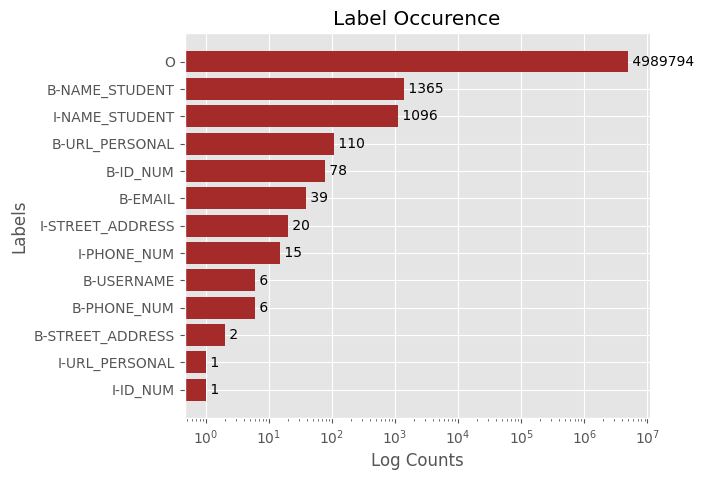

In [13]:
# Get useful lists
lables_list = np.concatenate(df['labels'].values)
unique_labels, label_counts = np.unique(lables_list, return_counts=True)
# sort
sorted_indices = np.argsort(label_counts)
unique_labels = unique_labels[sorted_indices]
label_counts = label_counts[sorted_indices]

plot_label_occurence(unique_labels, label_counts, title="Label Occurence")

We see that the data is heavily skewed with `Name` being the most occurring label after `O`. 

Some labels are very unrepresented, e.g. `I-URL_PERSONAL` and `I-ID_NUM`.

Also, `STREET_ADDRESS` and `PHONE_NUM` have more of the `I` than the `B`, probably because they consist of multiple components as we have already seen.


#### Label occurence - removing the BIO format

Let's look the label's count in the whole dataset where we remove the BIO format.

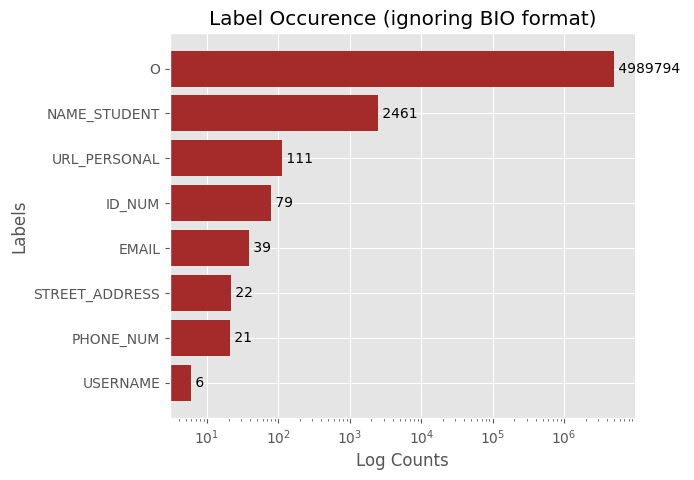

In [14]:
new_labels_list = [label[2:] if label != 'O' else label for label in lables_list]
unique_labels, label_counts = np.unique(new_labels_list, return_counts=True)
# sort
sorted_indices = np.argsort(label_counts)
unique_labels = unique_labels[sorted_indices]
label_counts = label_counts[sorted_indices]
plot_label_occurence(unique_labels, label_counts, title="Label Occurence (ignoring BIO format)")

Even though the `I`'s for both `URL_PERSONAL` and `ID_NUM` didn't occur very often, then their concatenated label is among top 3 and 4.

ALso, there is actually a very low count on `USERNAME`.

#### Sampled examples for each label

Randomly picking two samples from each label to see them more in detail.

In [15]:
data = data2notbio(label_2_word_list, bio2notbio)
for key, value in data.items():
    print(key)
    # sample 3
    n_samples = 2
    while n_samples > 0:
        try: 
            samples = random.sample(value, n_samples)
            n_samples = 0
        except:
            n_samples -= 1
    for sample in samples:
        print(f"    {sample}")

EMAIL
    kellyharrison@gmail.com
    john03@yahoo.com
ID_NUM
    188408534931
    VZ:775Y6A5764
NAME_STUDENT
    Gardner
    Cristino
PHONE_NUM
    (
    (
STREET_ADDRESS
    Erika
    ,
URL_PERSONAL
    https://hernandez.com/exploremain.html
    https://www.jackson.com/list/explorehomepage.htm
USERNAME
    meyermichelle
    castanedagabriel
O
    out
     


This qualitative analysis actually provide some powerful insights, namely that: 
- Emails are usually formatted with @
- The ID numbers seem to contain some prefix, and some specific length.
- Phone numbers typically contain prefix formatting for land areas.
- URLs usually contain https://
- Usernames typically also consist of the student's names




---

# More in-depth analysis

This analysis will go more in-depth for each label, in order to get a better understanding of how they behave in the documents.

Another goal of this analysis is to find powerful features that our heuristic model (the next notebook) can utilize to aid the process of identifying the PII labels.



Let's recap what was mentioned in the introduction:
1. **Distributions** of positional encoding, length, capital letters etc.
2. **Correlations** on co-occcurence.
3. **Similarities** based on N-grams and PCA.
4. **Context** of the words, what each label typically contains.
5. **Label specific** analysis, e.g. gender, ethnicity etc.

In the end we will be better equipped to construct useful features for modelling.

---


## Positional occurence

As we have already seen, most documents consist of more than 500 plus tokens. 

However, there might be some positional patterns as to when each label occurs within each student text.

#### PII position in documents

Let's look at where in a document the PII labels typically occur.

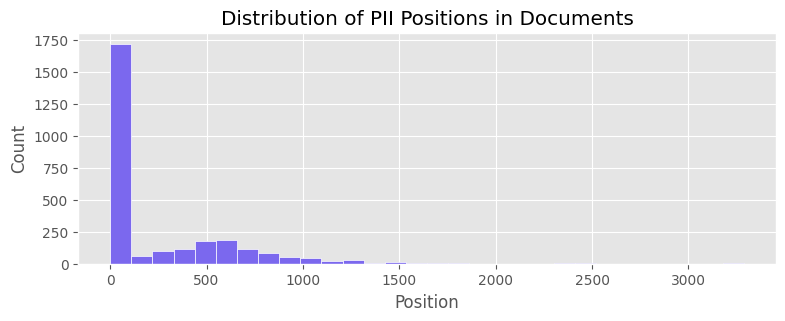

In [17]:
# Positions of PII
pos = np.concatenate([[i for i, ele in enumerate(entry) if ele != 'O'] for entry in df['labels']])
plot_positional_occurence(pos, "Distribution of PII Positions in Documents")

Generally the PII tags are at the start of the text, and after that, it seems like a normal distribution, similar to the distribution of token counts.

#### Normalized PII tag position in documents

Since the documents vary in length, all positional occurences are dependent on the length of the documents - except the start positions. 

Therefore we explore the positional occurence normalized by document length.

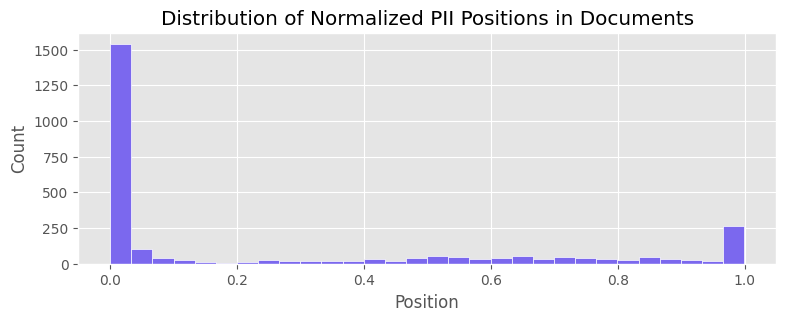

In [18]:
percentage_pos = np.concatenate([[i / len(entry)  for i, ele in enumerate(entry) if ele != 'O'] for entry in df['labels']])
plot_positional_occurence(percentage_pos, "Distribution of Normalized PII Positions in Documents")

As expected, the positional occurence in percentage indicates that the labels mostly occurrs at the start or end of each document - probably due to the formalities within a student text.

However, some labels still do occur in the middle of the documents.

#### Label position within documents

Next, let's look at the label positions for each label separately.

  2%|▏         | 167/6807 [00:00<00:03, 1660.10it/s]

100%|██████████| 6807/6807 [00:03<00:00, 1776.31it/s]


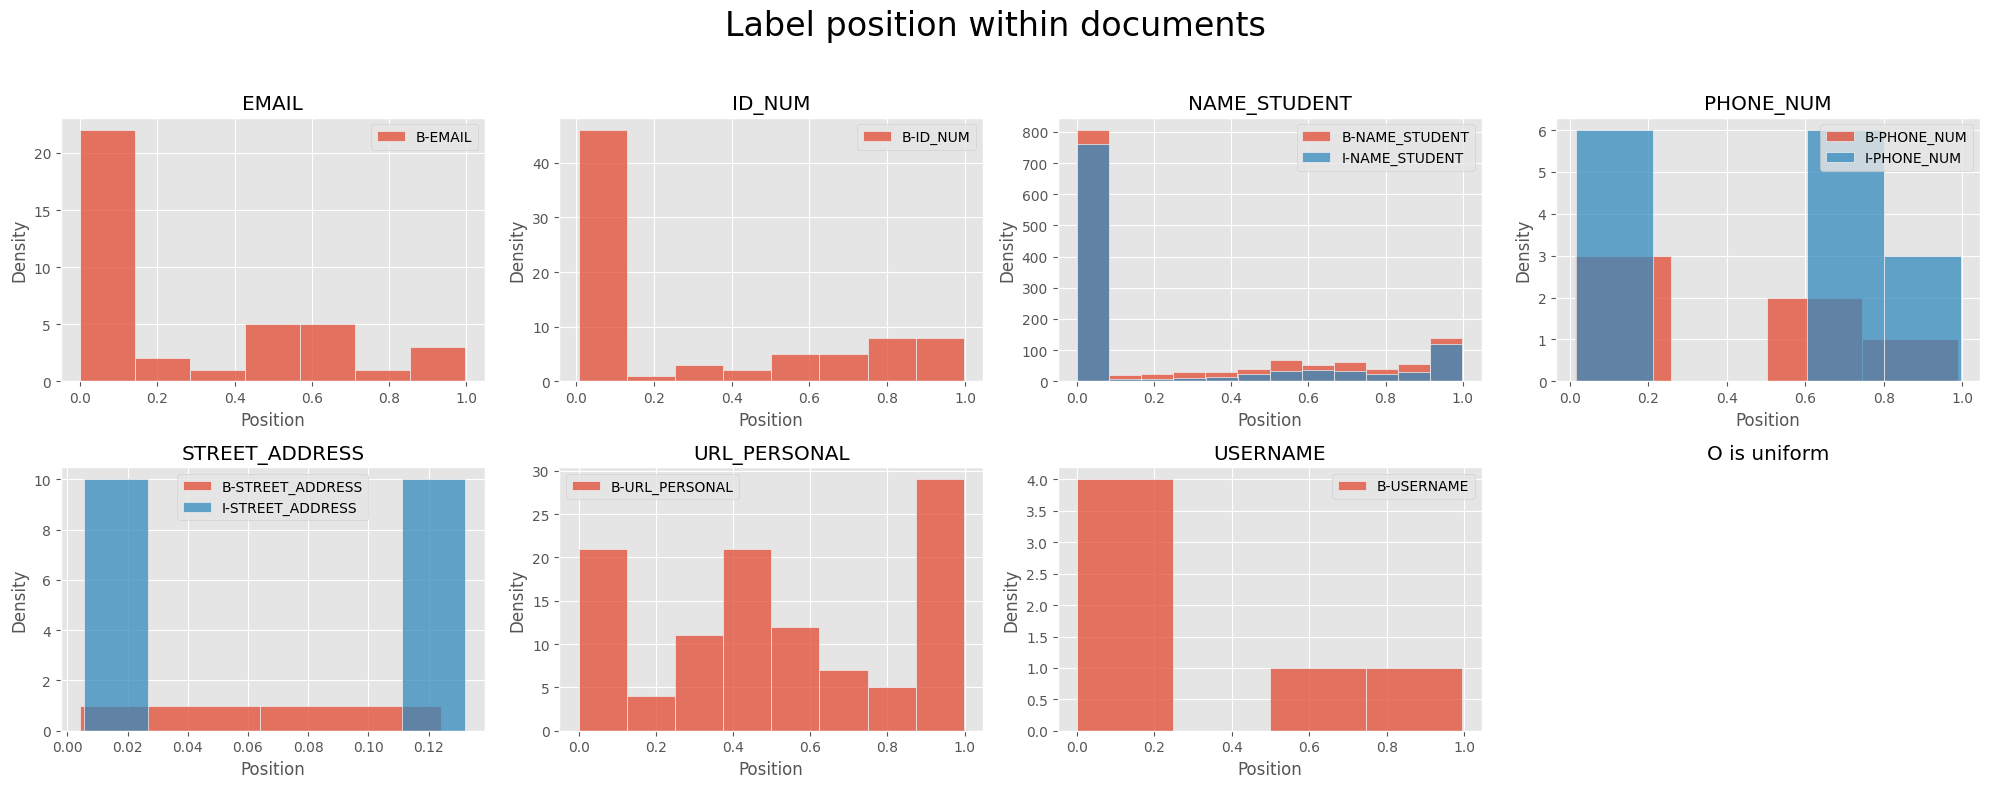

In [20]:
label_2_norm_positions = get_additional_data(dtype='norm_positions', labels=labels)
plot_label_histograms(label_2_norm_positions, 'Label position within documents', "Position", O="O is uniform")

In general the data seems to have a tendency for two modes, at the start and end of texts - however favoring the start.

Except `URL_PERSONAL` which also has a mode in the middle.


#### Label position in documents - excluding the BIO format

Next we'll remove the BIO format to generalize.

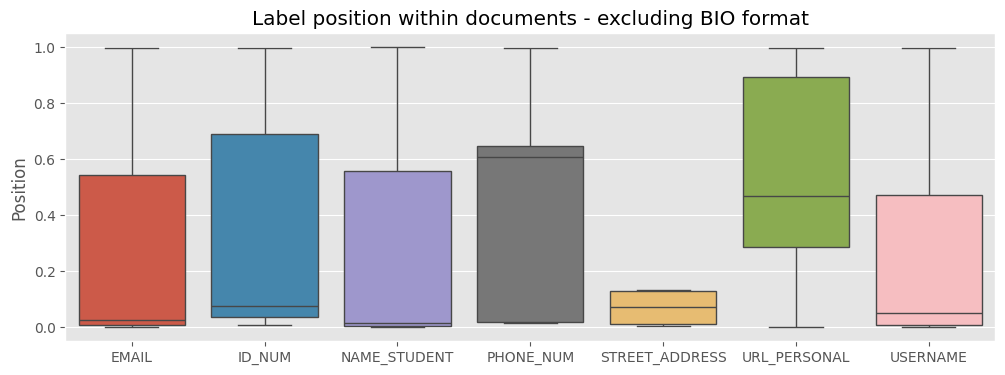

In [22]:
data = data2notbio(label_2_norm_positions, bio2notbio)
# but ignore 'O'
data.pop('O')

plot_label_boxplotdata(data, "Label position within documents - excluding BIO format", "Position")
# free up memory
del label_2_norm_positions

We further see that:
- `PHONE_NUMBER` tends more towards in the middle.
- `STREET_ADDRESS` is in the start without much variation.
- And `URL_PERSONAL` favors the middle and the end.

All these tendencies are somewhat hard to explain but can provide meaningful insights during modelling.

---

## Label lengths


Another useful insight could be the general token length for each label - i.e. counting number of characters.

Especially since it seemed like the label `ID_NUM` followed some strict patterns.


#### Label lengths in documents

Looking at the distribution of number of characters per token for each label.

100%|██████████| 6807/6807 [00:04<00:00, 1691.35it/s]


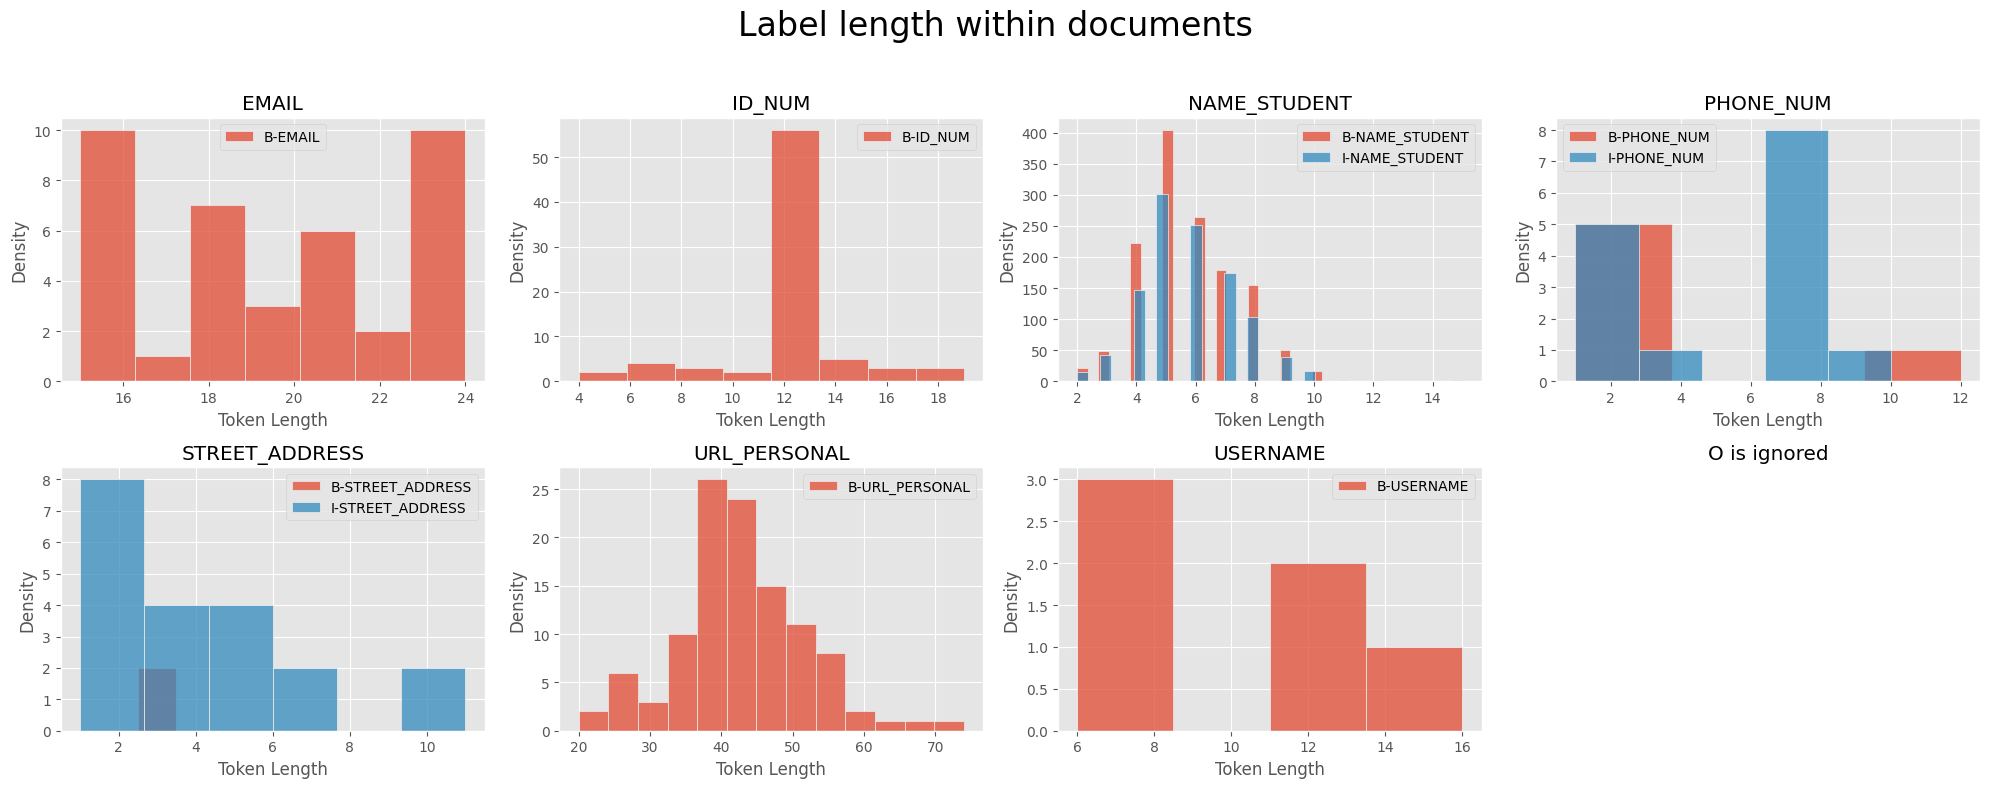

In [23]:
label_2_word_lengths = get_additional_data(dtype='word_lengths', labels=labels)
plot_label_histograms(label_2_word_lengths, 'Label length within documents', "Token Length", O="O is ignored")

There is a clear difference in the distributions of each label, we see that:
- Both `B` and `I` for `NAME_STUDENT` are almost identical.
    - but for the `PHONE_NUM` there is a difference, probably due to phone number prefixes.
- `ID_NUM` seems to favor a length of 12 with few outliers, this supports the previous assumption.

#### Label lengths in documents excluding the BIO format

Let's remove the BIO format.

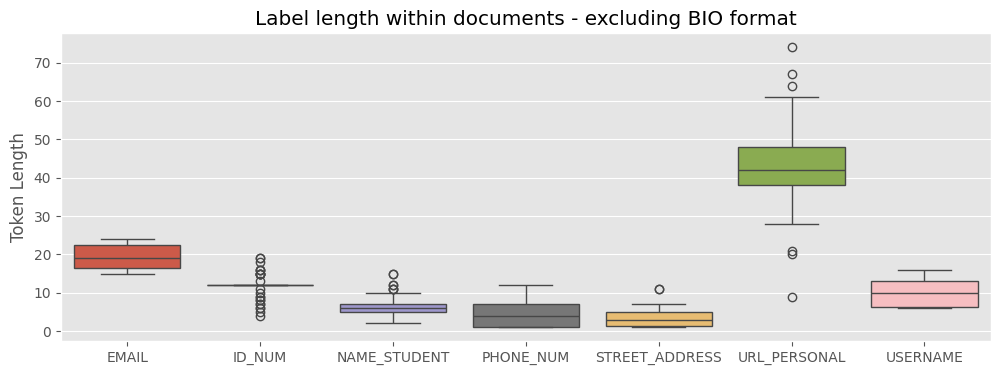

In [24]:
data = data2notbio(label_2_word_lengths, bio2notbio)
# but ignore 'O'
data.pop('O')
plot_label_boxplotdata(data, "Label length within documents - excluding BIO format", "Token Length")
# free up memory
del label_2_word_lengths

By joining each interclass BIO, the differences become even more apparent, especially how `ID_NUM` seems very fixed on 12 with little variance, and that `EMAIL` and `URL_PERSONAL` are generally longer.

In [ ]:
# let's sample some from 'O' to reduce
label_2_word_list['O'] = random.sample(label_2_word_list['O'], 1000)

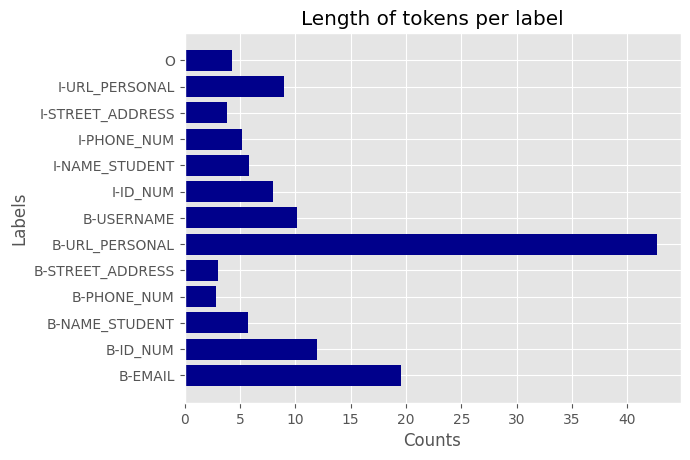

In [ ]:
data = {}
for label in labels:
    data[label] = np.mean([len(token) for token in label_2_word_list[label]])

barh_plot(data, "Length of tokens per label", "darkblue")

On average URLs are quite long, as well as emails.

### Additional regsex and token analysis

#### Capitalized

One assumption is that some labels must be capitalized in their first character - e.g. `NAME_STUDENT`. 

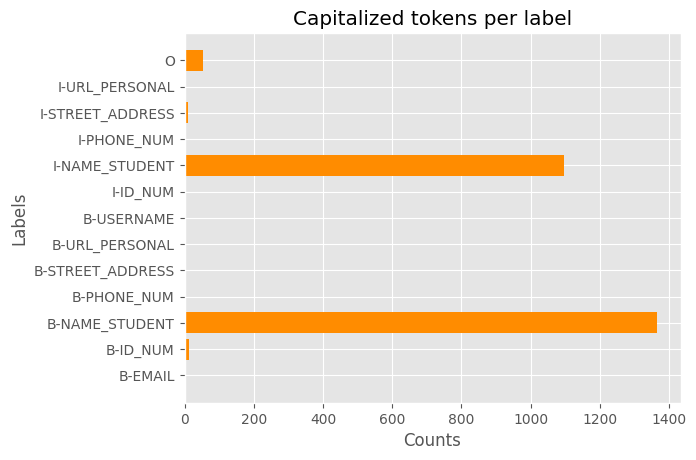

In [26]:
data = {}
for label in labels:
    data[label] = sum([token[0].isupper() for token in label_2_word_list[label]])
barh_plot(data, "Capitalized tokens per label", "darkorange")

We see that most of the student names mostly consist of capitalized letters, but unexpectedly street names does not.

#### % containing numbers

Another assumption is that some of the labels contain some numbering.

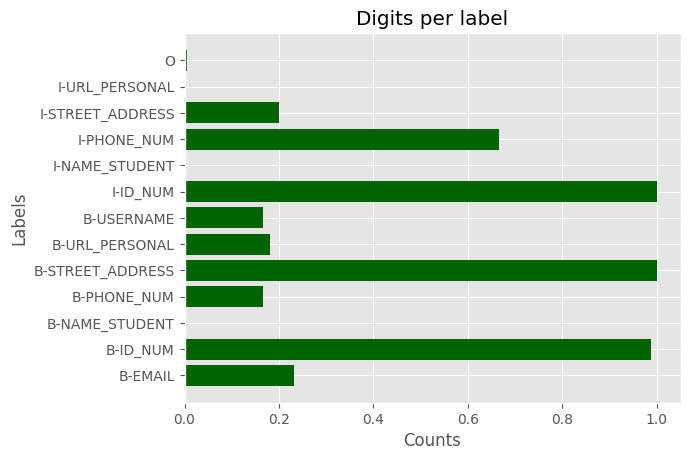

In [62]:
data = {}
for label in labels:
    data[label] = np.mean([any(char.isdigit() for char in token) for token in label_2_word_list[label]])

barh_plot(data, "Digits per label", "darkgreen")

We see that student ID's typically consist of numbers, as well as street address and phone numbers.

Another interesting point is that `O` does not contain numbers at all.

#### Contains punctuation

Checking the distribution of labels containing punctuation.

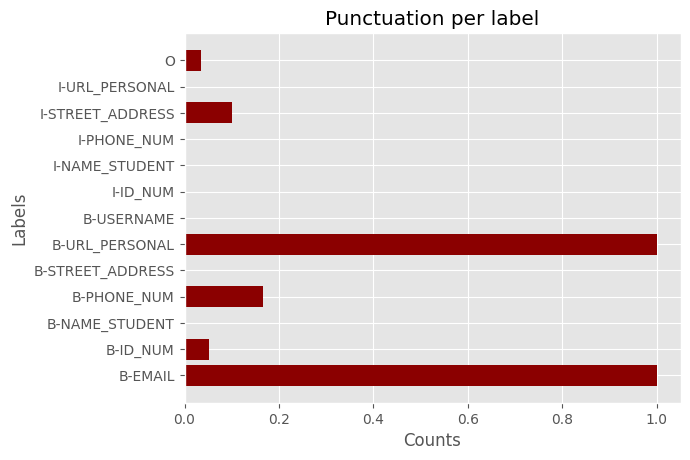

In [61]:
data = {}
for label in labels:
    data[label] = np.mean(['.' in token for token in label_2_word_list[label]])

barh_plot(data, "Punctuation per label", "darkred")

This is interesting and indicates that punctuation can tell alot about URLs and emails.

#### Has stopwords

Finally, let's investigate the use of stop words.

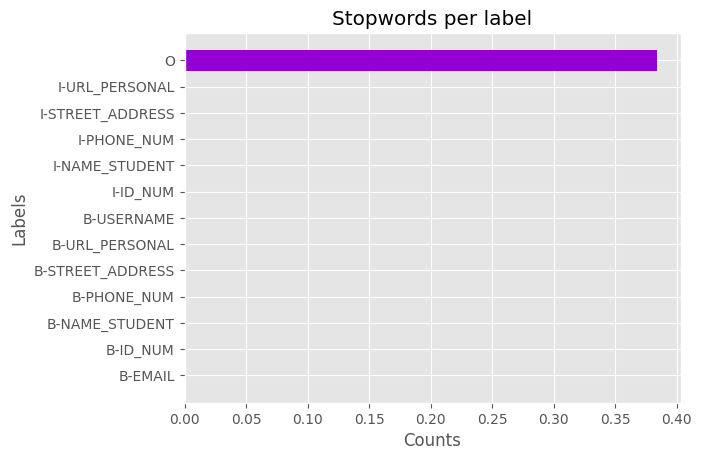

In [65]:
# stopwords
from nltk.corpus import stopwords
data = {}
for label in labels:
    data[label] = np.mean([token.lower() in stopwords.words('english') for token in label_2_word_list[label]])

barh_plot(data, "Stopwords per label", "darkviolet")

This can significantly help in finding some of the `O`'s, since none of the other labels contain stop words.

In [31]:
label_2_word_list = get_additional_data(dtype='word_list', labels=labels)

100%|██████████| 6807/6807 [00:04<00:00, 1660.36it/s]


---

## Correlation using co-occurence


Another interesting insight is how each label co-occurs with another across each document, since this can indicates some form of correlation.

To investigate this, each labels is 'documented' across all the documents, and the matrix is multiplied to get a form of correlation.


#### The Co-Occurence Matrix

It indicates how much one label occurs with another when it is present.

In [33]:
tf_doc_occurrences = (doc_occurrences > 0) * 1
# keep only B- 
current_labels = [label for label in labels if label.startswith('B-')]
tf_doc_occurrences = tf_doc_occurrences[current_labels]
co_occurrences = tf_doc_occurrences.T @ tf_doc_occurrences

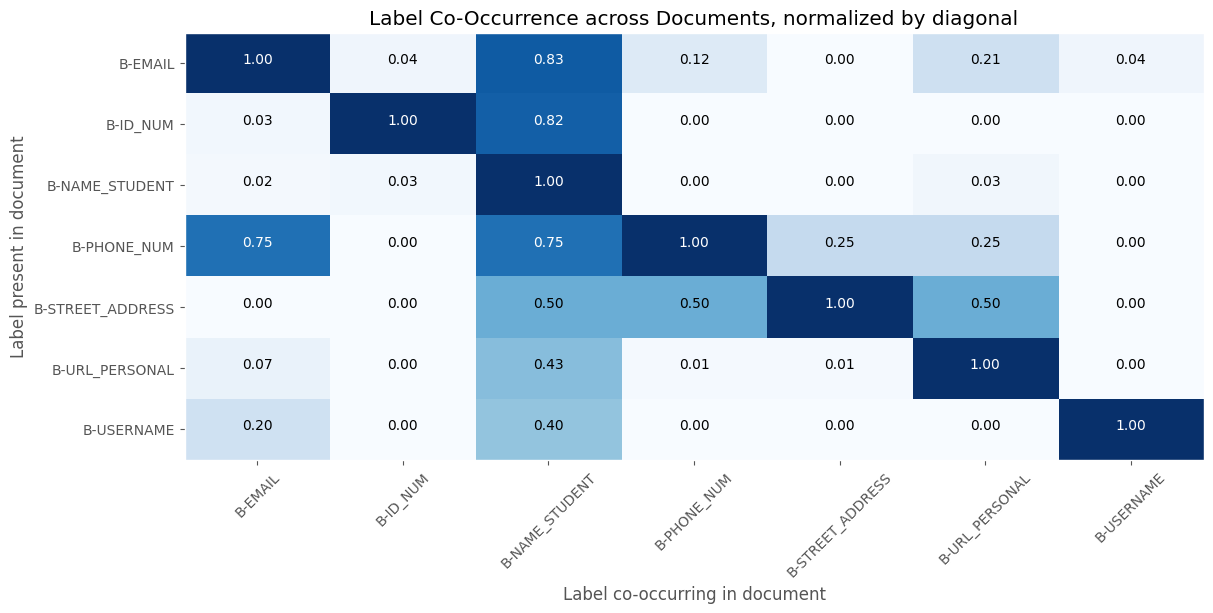

In [34]:
# plot as a confusion matrix
plot_matrix(co_occurrences.values, current_labels, title='Label Co-Occurrence across Documents', figsize=(12, 6),
            ylabel='Label present in document', xlabel='Label co-occurring in document')

In order to understand the plot, take e.g. row `B-EMAIL`; if `B-EMAIL` occurs within a document, the plot indicates that 83% of the time `B-NAME_STUDENT` is also present. 

Thus in general, the highly colored `B-NAME_STUDENT` column indicates that it co-occurs alot when the other variables are present - i.e. we rarely see `B-EMAIL` without also seeing  `B-NAME_STUDENT`.


We also see that when `B-PHONE_NUM` is present, then `B-EMAIL` is often co-occurs too.


#### The Co-Occurence Graph

Another way of visualizing this relationship with a graph - which is also more visually appealing.

To do this we model each of the labels relation as an edge in which the labels are the nodes. To further make it more visually appealing, each edge is weighted by their co-occurence score.

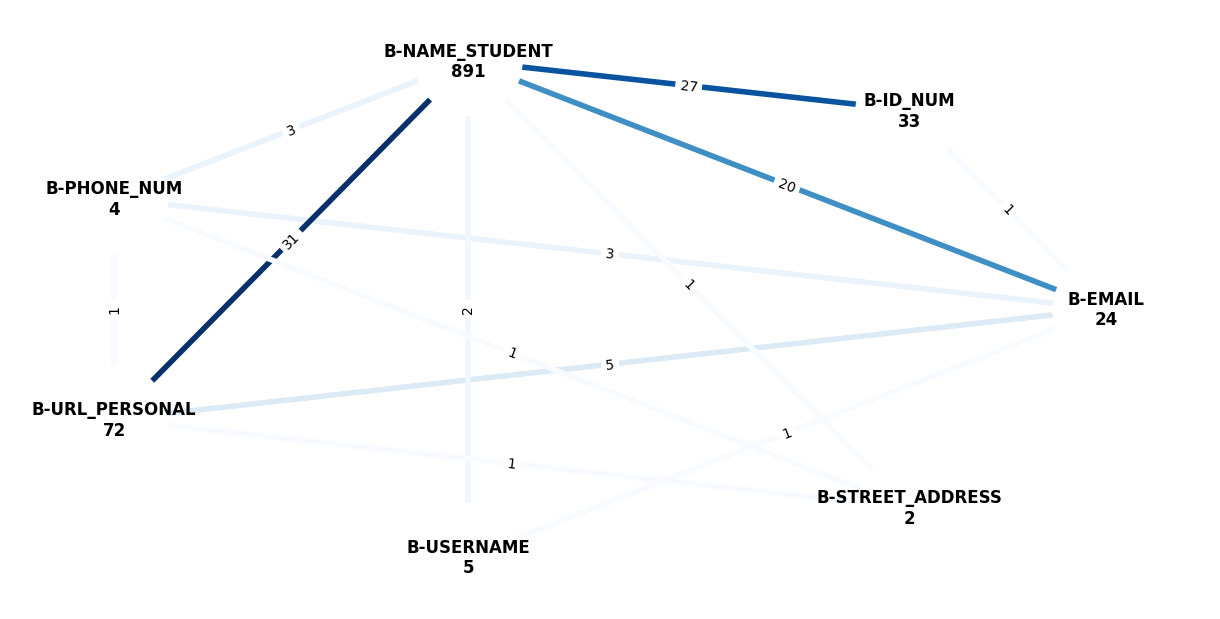

In [35]:
import networkx as nx
# Create a graph
G = nx.Graph()

# Add nodes and edges based on the co-occurrence matrix
n = len(co_occurrences)
edge_labels = {}
for i in range(n):
    for j in range(n):
        # ignore self-connections
        if i != j:
            if co_occurrences.values[i][j] > 0:
                G.add_edge(i, j, weight=co_occurrences.values[i][j], label=f"{co_occurrences.values[i][j]}")
                edge_labels[(i, j)] = co_occurrences.values[i][j]
# Add nodes with labels
node2label = {i: label + f"\n{co_occurrences.values[i][i]}" for i, label in enumerate(current_labels)}
# set ffig size
plt.figure(figsize=(12, 6))
#pos = nx.spring_layout(G)  # positions for all nodes
pos = nx.circular_layout(G)
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw(G, pos, 
        arrows=True, width=4, edge_color=weights, edge_cmap=plt.cm.Blues,
        with_labels=True, labels=node2label,
        node_color='white', node_size=6000, font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='black'
)
plt.show()

To summarize:
- This graph shows the relationships between the labels more clearly.
- Specifically, we see that `B-NAME_STUDENT` often co-occurs with the labels `B-URL_PERSONAL`, `B-ID_NUM` are `B-EMAIL` - so we rarely see these labels without also seeing `B-NAME_STUDENT`.
- But we also see that `B-NAME_STUDENT` most often occurs by itself - relative to the others.
- And that in general, most of the labels do not occur very often.

The insights from both visualizations indicate some important possibilities:
- `B-NAME_STUDENT` is the main component that is inter-connected with all the other labels.
- Furthermore, say e.g. `B-EMAIL` is easy to find by @, then this can contribute to finding `B-NAME_STUDENT` due to their co-occurence and vice-versa.

To sum up, we see that the `B-NAME_STUDENT` is very correlated with alot of the features, signifying its hierarchical importance. I.e. by first classifying a name, it could potentially contribute to classifying the rest of the labels - and vice versa, i.e. positive reinforcement.

---

## Label similarities

Another insight could be some similarity measures between the tokens themselves for each label.

To achieve this, we can utilize character n-grams for each token together with TF-IDF to get a vector representation, and then we can apply PCA to visualize the results.

In [36]:
# concatenate all tokens
all_tokens = []
all_token_labels = []
for label in labels:
    # subsample 100 from each label - if possible
    to_add = label_2_word_list[label][:100]
    all_tokens.extend(to_add)
    all_token_labels.extend([label] * len(to_add))

In [37]:
# Using character n-grams from length 2 to 5
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 8))
X = vectorizer.fit_transform(all_tokens)
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X.toarray())

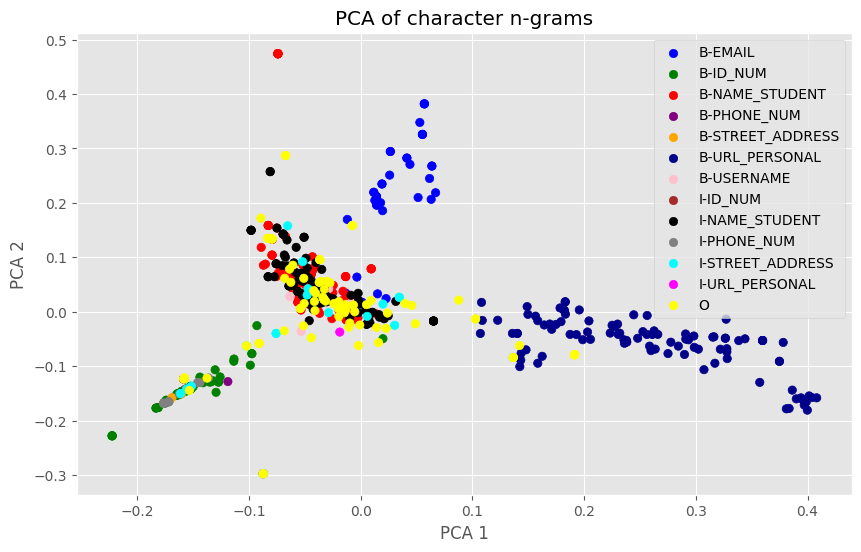

In [39]:
# plot pca
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[label2color[label] for label in all_token_labels])#, alpha=0.5)
# add a legend
for label, color in label2color.items():
    plt.scatter([], [], c=color, label=label)
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of character n-grams")
plt.show()

We see that a lot of the points are mixed in the middle and inseparable. However, `B-ID_NUM`, `B-EMAIL` and `B-URL_PERSONAL` how some separability, indicating they have some unique n-grams - this is probably due to some of their special formatting.

---

## Context using Word frequencies

Let's look at the most populare words and tokens for each label.

Note that the word cloud generator does its own form of tokenization.


#### Word cloud on each label

Here, each word is displayed wrt. its frequency in a visually distinct manner on the word cloud. The size of each word is proportional to its occurrence in the dataset corresponding to the specific label, allowing for an immediate visual understanding of the most common terms associated with each label.

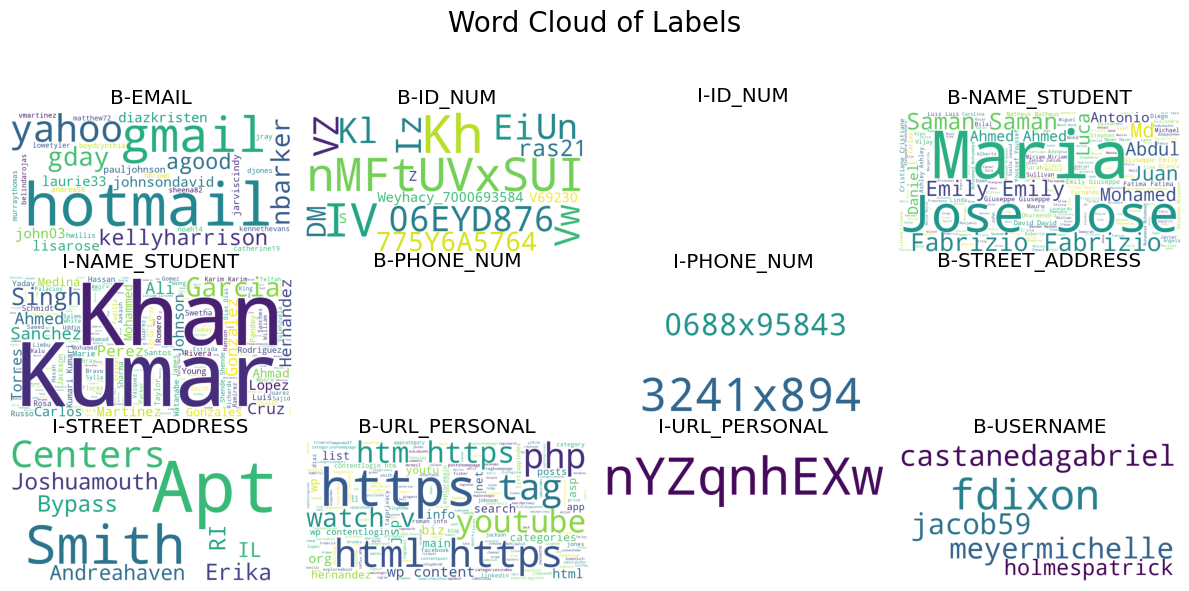

In [42]:
plot_word_cloud(label_2_word_list, "Word Cloud of Labels")

We see that there are some general tendencies within each label that might prove useful - e.g. for emails, phone numbers and personal urls.


### Word cloud on tokens before a label

The context in which a label appears can have some significance.

In this regard we will look at the typical words occuring before a label, and then also after a label.

Notice that the `None` string indicates that no token was found before/after a label. 

100%|██████████| 6807/6807 [00:21<00:00, 319.62it/s]


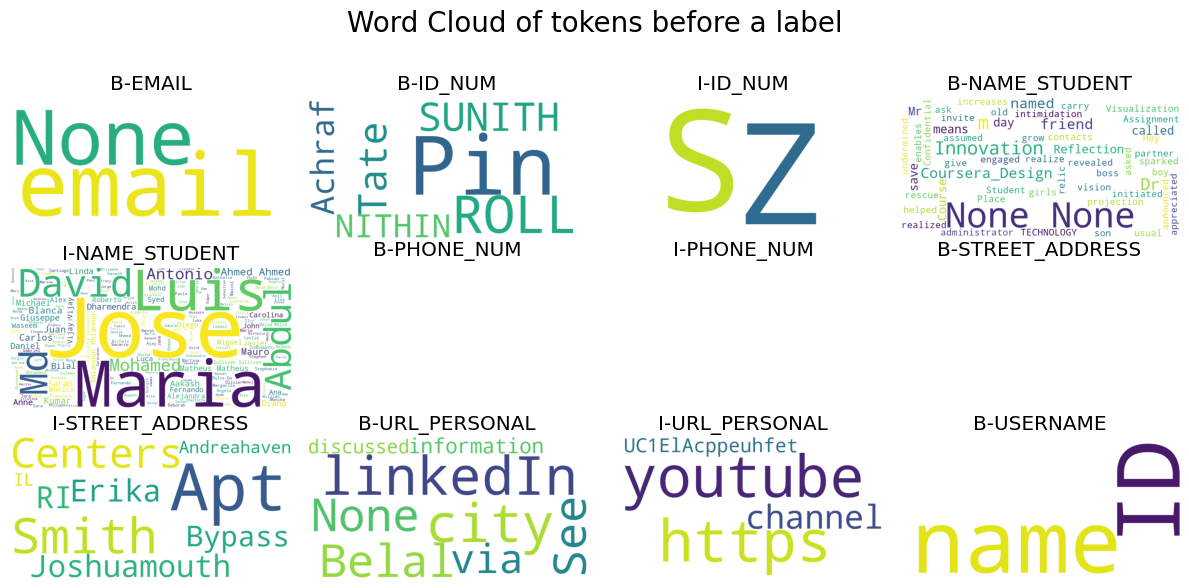

In [43]:
label_2_context_before = get_additional_data(dtype='context_before', labels=labels)
plot_word_cloud(label_2_context_before, "Word Cloud of tokens before a label")

We see that the string `None` often appears before `B-EMAIL` and `B-NAME_STUDENT`, indicating that the label is often at the start of the document. Furthermore, the words before `B-EMAIL` are mostly "email", and before `B-USERNAME` are usually "name" and "ID".

These insights are useful for modelling.

However, another question arises: why are a lot of the word clouds just empty?

In [44]:
# exampels, focus on B
print(f"B-PHONE_NUM: {label_2_context_before['B-PHONE_NUM'][:3]}")
print(f"B-STREET_ADDRESS: {label_2_context_before['B-STREET_ADDRESS'][:3]}")

# free up memory
del label_2_context_before

B-PHONE_NUM: [' ', ':', ':']
B-STREET_ADDRESS: [' ', '-']


This comes to show that most words clouds aren't really empty, but rather they contains spaces and symbols - which can be useful.

### Word cloud on tokens after a label

Next up, the tokens occuring after a label - and note, the `B` labels will probably consist of theri `I` labels. 

  0%|          | 0/6807 [00:00<?, ?it/s]

100%|██████████| 6807/6807 [00:22<00:00, 300.19it/s]


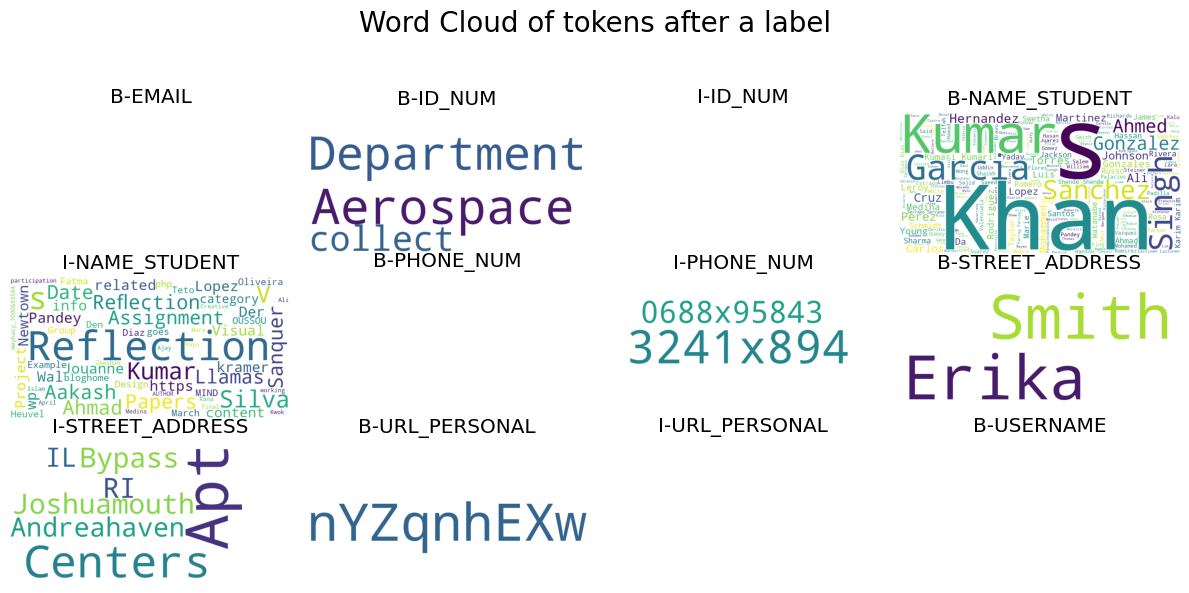

In [45]:
label_2_context_after = get_additional_data(dtype='context_after', labels=labels)
plot_word_cloud(label_2_context_after, "Word Cloud of tokens after a label")

Not much to note, except, we see a lot more empty word clouds indicating symbols and spaces.

Let's investigate the empty word clouds:

In [46]:
# examples, focus on I
print(f"B-EMAIL: {label_2_context_after['B-EMAIL'][:3]}")
print(f"I-ID_NUM: {label_2_context_after['I-ID_NUM'][:3]}")
print(f"I-URL_PERSONAL: {label_2_context_after['B-URL_PERSONAL'][:3]}")
print(f"B-USERNAME: {label_2_context_after['B-USERNAME'][:3]}")

# free up memory
del label_2_context_after

B-EMAIL: [' ', '\n\n', ',']
I-ID_NUM: ['\n\n']
I-URL_PERSONAL: ['\n\n', '     ', '    ']
B-USERNAME: ['but', '|', '|']


The same case as we saw before, but with line breaks as well.

---

## Label specific analysis

Next up, but also last, we'll look at each label more in depth by considering some of their unique characteristics.


### NAME_STUDENT

We'll start by analysing the `NAME_STUDENT` separably.

In [47]:
# list of all the names
names = label_2_word_list['B-NAME_STUDENT'] + label_2_word_list['I-NAME_STUDENT']

#### Gender prediction

Let's use a gender prediction model to see some the it's distributions.

In [48]:
gender_detector = gender.Detector()
genders = [gender_detector.get_gender(name) for name in names]
uniques, counts = np.unique(genders, return_counts=True)

C:\Users\adj\AppData\Local\Temp\ipykernel_26916\3444565261.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(uniques, rotation=45);


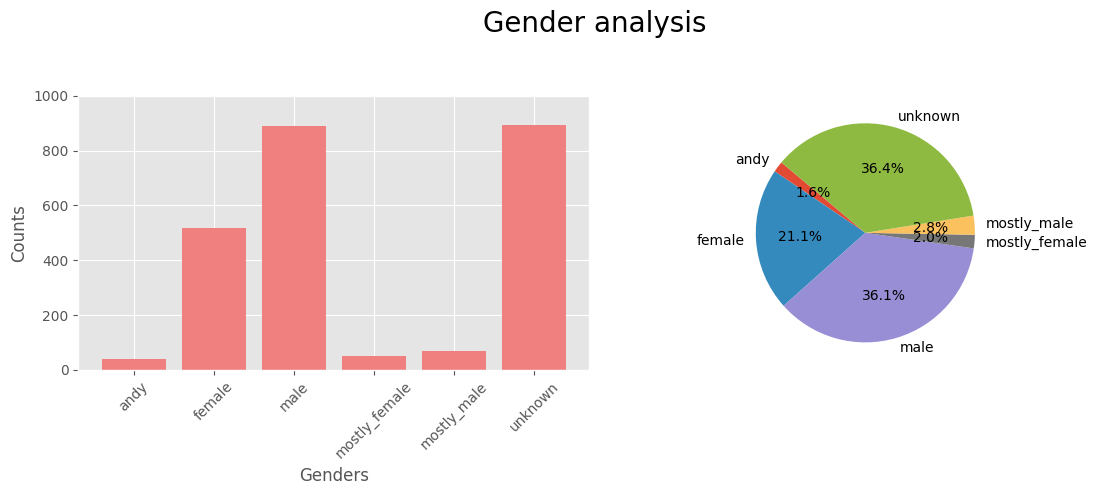

In [49]:
# two plots, bar and pie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# bar plot
axs[0].bar(uniques, counts, color="lightcoral")
axs[0].set_yticks(axs[0].get_yticks().tolist())
axs[0].set_xticklabels(uniques, rotation=45);
axs[0].set_xlabel("Genders")
axs[0].set_ylabel("Counts")

# pie plot
axs[1].pie(counts, labels=uniques, autopct='%1.1f%%', startangle=140)
fig.suptitle("Gender analysis" + '\n', fontsize=20)
plt.tight_layout()
plt.show()

The data seems to be biased towards male's, however, there are a lot of unknowns.

But this could also indicate that male's write their names on essays more often.

Let's look at the names contained within each gender prediciton group.

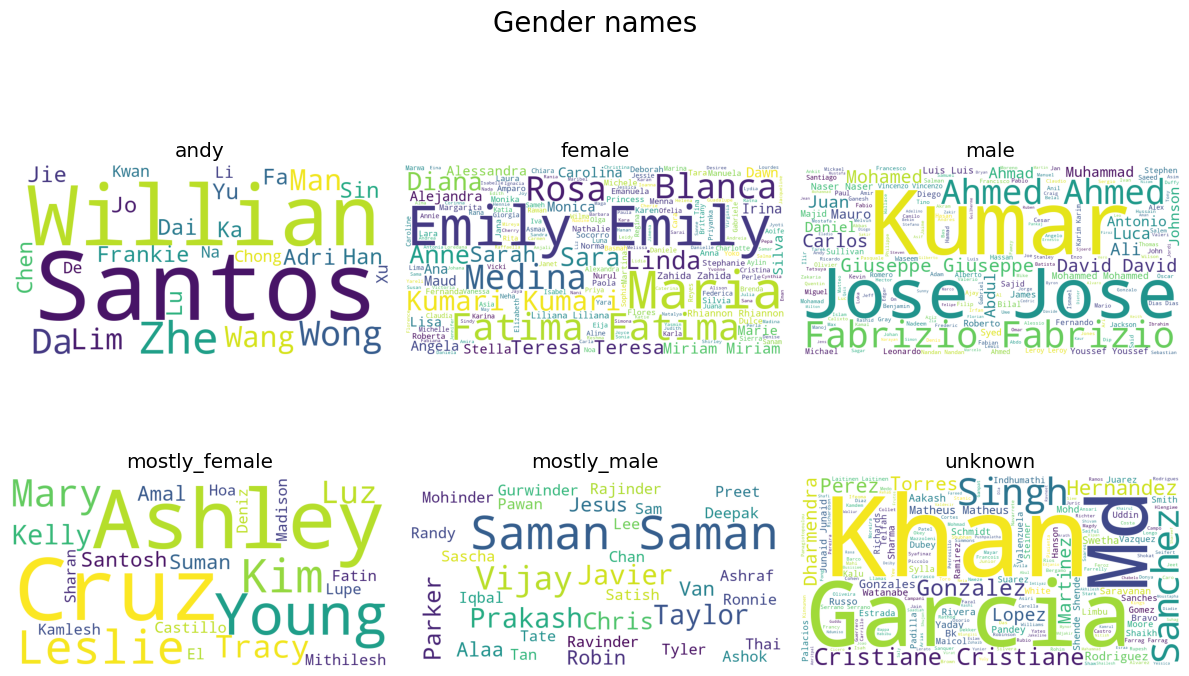

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# NOTE: there are only 6 shown
axs = axs.flatten()
dropped = 0
for i, _gender in enumerate(uniques):
    axs[i].axis('off')
    names_list = [name for (name, gender) in zip(names, genders) if gender == _gender]
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(names_list))
    axs[i].imshow(wordcloud)
    axs[i].set_title(_gender)
fig.suptitle("Gender names", fontsize=20)
plt.tight_layout()
plt.show()

This plots shows that even though the texts are in english, there seems to be names of multitple ethnic backgrounds.

#### Ethnicity prediction

Given the insight above, let's look at an ethnic classifier and some of the distributions.

In [51]:
ec = EthnicClassifier.load_pretrained_model();

c:\Users\adj\AppData\Local\anaconda3\envs\42578\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\adj\AppData\Local\anaconda3\envs\42578\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [52]:
nationalities = ec.classify_names(names)
code_to_nationality = {
    'chi': 'Chinese',
    'eng': 'English',
    'frn': 'French',
    'ger': 'German',
    'ind': 'Indian',
    'ita': 'Italian',
    'jap': 'Japanese',
    'mea': 'Middle-Eastern',
    'rus': 'Russian',
    'spa': 'Spanish',
    'vie': 'Vietnamese',
    'kor': 'Korean'
}
print(len(code_to_nationality))
new_nationalities = [code_to_nationality[nationality] for nationality in nationalities]
uniques, counts = np.unique(new_nationalities, return_counts=True)


12


C:\Users\adj\AppData\Local\Temp\ipykernel_26916\2088754048.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(uniques, rotation=45);


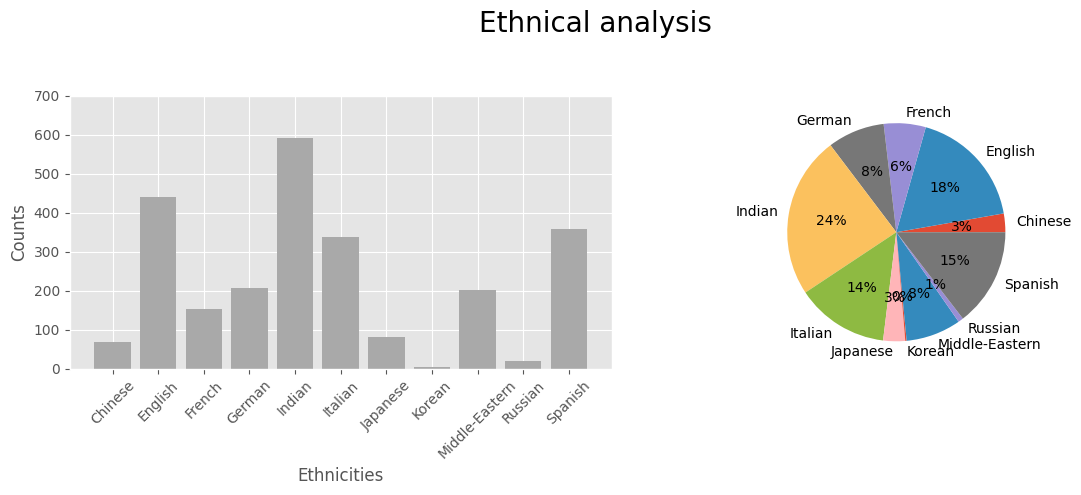

In [53]:
# two plots, bar and pie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# bar plot
axs[0].bar(uniques, counts, color="darkgrey")
axs[0].set_yticks(axs[0].get_yticks().tolist())
axs[0].set_xticklabels(uniques, rotation=45);
axs[0].set_xlabel("Ethnicities")
axs[0].set_ylabel("Counts")

# pie plot
axs[1].pie(counts, labels=uniques, autopct='%1.0f%%', startangle=0)
fig.suptitle("Ethnical analysis" + '\n', fontsize=20)
plt.tight_layout()
plt.show()

We see that most names are English, Indian, Italian and Spanish - however quite evenly spread nonetheless.

This could indicate that the student essays are from a more international school, or maybe that the essay's are collected form multiple places in the world.


However, given that the names are international, some model might have a hard time classifying them due to their uniqueness.

### EMAIL

Most emails consist of @ follow by a domain, let's look at that more closely.

In [54]:
data = data2notbio(label_2_word_list, bio2notbio)
# extract domain
domains = [email.split("@")[-1] for email in data['EMAIL']]
len(domains)
uniques, counts = np.unique(domains, return_counts=True)

C:\Users\adj\AppData\Local\Temp\ipykernel_26916\120355424.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(uniques, rotation=45);


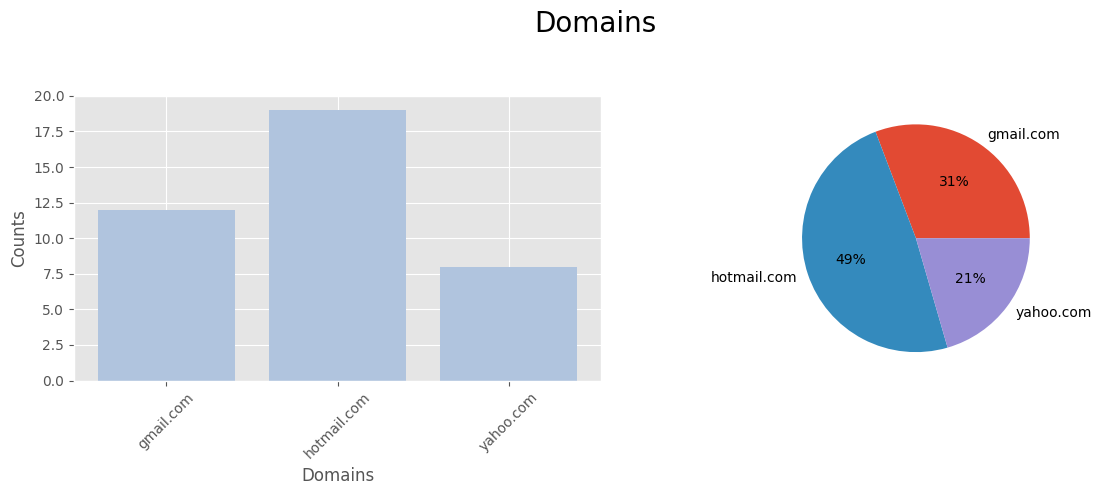

In [55]:
# two plots, bar and pie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# bar plot
axs[0].bar(uniques, counts, color="lightsteelblue")
axs[0].set_yticks(axs[0].get_yticks().tolist())
axs[0].set_xticklabels(uniques, rotation=45);
axs[0].set_xlabel("Domains")
axs[0].set_ylabel("Counts")

# pie plot
axs[1].pie(counts, labels=uniques, autopct='%1.0f%%', startangle=0)
fig.suptitle("Domains" + '\n', fontsize=20)
plt.tight_layout()
plt.show()

This comes to show that classifying email should be rather trivial.

In [56]:
# do all contain @?
_not = [e for e in uniques if "@" not in e]
print(len(_not))
_not

3


['gmail.com', 'hotmail.com', 'yahoo.com']

We see that some are solely the domain.

### STREET ADDRESS

We know that addresses sually contain some formatting such as; 
- Suffix e.g., Street, Avenue, Road
- Numbering
- Capitalization


In [57]:
data['STREET_ADDRESS'][:9]

['591', '743', 'Smith', 'Centers', 'Apt', '.', '656', '\n', 'Joshuamouth']

Note: we see some of the formatting.

### Phone number

Usually consist of land codes and other formatting.

In [58]:
data['PHONE_NUM'][:9]

['(', '(', '(', '(', '(', '410.526.1667', '320)202', '-', '0688x95843']

We see some of the formatting.

## To conclude

The data exploration analysis has provided us with some useful insights to utilize within our heuristic model.

The analysis might seem exhausted, however, there are probably a lot of other interesting remarks to find within the data.

We have also seem some of the biases within the data, as well as how the data behaves in general.


We are now ready to do some modelling.